# Dependencies

In [2]:
import os
import copy
import pandas as pd
import numpy as np
import netCDF4 as nc
import sys
import xarray as xr
import scipy as sp
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import NearestNDInterpolator
import tqdm
import glob
import time
from xrft import xrft
import subprocess
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import palettable
from moarpalettes import get_palette

## matplotlib rcParams
## IF you want to use thesis style

import requests
from io import StringIO, BytesIO

req = requests.get('https://raw.githubusercontent.com/njleach/Thesis/main/ancil/figure-style.mplstyle')

with open("/home/l/leach/thesis.mplstyle", "w") as text_file:
    text_file.write(req.content.decode())
    
plt.style.use("/home/l/leach/thesis.mplstyle")
textwidth = matplotlib.rcParams['figure.figsize'][0]

# FUNCTIONS

In [8]:
def fourier_truncate(ds,truncate=0.3):
    
    """
    Spectral truncation of data using FT.
    
    truncate = truncation level in maximum allowed frequency per degree
    """
    
    # fft
    ds_fft = xrft.fft(ds,dim=['latitude','longitude'],true_phase=True,true_amplitude=True)

    # truncate
    ds_fft = ds_fft.where(np.sqrt(ds_fft.freq_longitude**2+ds_fft.freq_latitude**2)<truncate,0)

    # invert
    ds_ifft = xrft.ifft(ds_fft,dim=['freq_longitude','freq_latitude'],true_phase=True,true_amplitude=True)

    return ds_ifft

def truncate_and_save(fpath,add_msl=True):
    
    ds_fname = fpath.split('/')[-1].split('.')[0]
    
    ds = xr.open_dataset(fpath)
    print('loaded pl data',flush=True)
    ds = ds.vo.sel(level=850,time=(ds.time.dt.hour%3)==0)
    ds = ds.sel(time=slice('2022-02-10','2022-02-22'))
    print('truncating vo data',flush=True)
    ds_trunc = fourier_truncate(ds).sortby('latitude',ascending=False)
    print('truncated vo data',flush=True)
    
    if add_msl:
        ds = xr.open_dataset(fpath.replace('/pl/','/sfc/')).get(['msl'])
        ds = ds.sel(time=ds_trunc.time)
        print('loaded msl data',flush=True)
        
        if 'number' in ds.coords:
            ds['vo'] = (('time','number','latitude','longitude'),ds_trunc.real.values)
            print('saving member files',flush=True)
            [ds.sel(number=x).to_netcdf('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEin_{}_{}.nc'.format(ds_fname,x)) for x in ds.number.values]
            in_paths = ['/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEin_{}_{}.nc'.format(ds_fname,x) for x in ds.number.values]
        else:
            ds['vo'] = (('time','latitude','longitude'),ds_trunc.real.values)
            print('saving control file',flush=True)
            ds.to_netcdf('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEin_{}_{}.nc'.format(ds_fname,0))
            in_paths = ['/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEin_{}_{}.nc'.format(ds_fname,0)]
    else:
        if 'number' in ds.coords:
            [ds_trunc.real.sel(number=x).to_netcdf('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEin_{}_{}.nc'.format(ds_fname,x)) for x in ds.number.values]
            in_paths = ['/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEin_{}_{}.nc'.format(ds_fname,x) for x in ds.number.values]
        else:
            ds_trunc.real.to_netcdf('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEin_{}_{}.nc'.format(ds_fname,0))
            in_paths = ['/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEin_{}_{}.nc'.format(ds_fname,0)]
                
    with open('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TE_nc_in_list.txt','w') as f:
        f.writelines([x+'\n' for x in in_paths])
    with open('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TE_DN_out.txt','w') as f:
        f.writelines([x.replace('TEin','TENodes').replace('.nc','')+'\n' for x in in_paths])
        
def run_TE(fpath):
    
    truncate_and_save(fpath)
    
    print('Node detection across files',flush=True)

    DetectNodes_args = []
    DetectNodes_args += ['DetectNodes']

    DetectNodes_args += ['--in_data_list','/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TE_nc_in_list.txt']
    DetectNodes_args += ['--out_file_list','/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TE_DN_out.txt']
    DetectNodes_args += ['--closedcontourcmd','msl,200,6.0,0']
    DetectNodes_args += ['--thresholdcmd','vo,>,1e-4,4.0']
    DetectNodes_args += ['--mergedist','2.0']
    DetectNodes_args += ['--searchbymin','msl']
    DetectNodes_args += ['--outputcmd','msl,min,3;vo,max,0']
    DetectNodes_args += ['--timefilter','6hr']
    DetectNodes_args += ['--latname','latitude']
    DetectNodes_args += ['--lonname','longitude']
    DetectNodes_args += ['--regional']
    
    DN_out = subprocess.run(DetectNodes_args,stdout=subprocess.PIPE)
    
    print('Node stitching across files',flush=True)

    with open('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TE_DN_out.txt','r') as f:
        nodefiles = [x.strip() for x in f.readlines()]
        
    for nodefile in nodefiles:
    
        StitchNodes_args = []
        StitchNodes_args += ['StitchNodes']

        StitchNodes_args += ['--in_fmt','lon,lat,msl,vo']
        StitchNodes_args += ['--in',nodefile]
        StitchNodes_args += ['--out',nodefile.replace('TENodes','TEStitch')]
        StitchNodes_args += ['--range','5.0']
        StitchNodes_args += ['--mintime','24h']
        StitchNodes_args += ['--maxgap','6h']
        StitchNodes_args += ['--min_endpoint_dist','9.0']
        StitchNodes_args += ['--out_file_format','csv']
    
        SN_out = subprocess.run(StitchNodes_args,stdout=subprocess.PIPE)
    
def read_nodes(fpath):
    
    with open(fpath,'r') as f:
        lines = f.readlines()

    readout = []
    for line in lines:

        if line[:1] != '\t':
            year,mon,day,num,hr = line.replace('\n','').split('\t')
            date = pd.to_datetime('{:04d}-{:02d}-{:02d} {:02d}'.format(int(year),int(mon),int(day),int(hr)))
        else:
            _,idxlon,idxlat,lon,lat,p_min,vo_max = line.replace('\n','').split('\t')
            readout += [[float(lon),float(lat),float(p_min),float(vo_max),date]]
            
    return pd.DataFrame(data=readout,columns=['lon','lat','p_min','vo_max','date'])

# IMPORT DATA

# Run TE
Run with timefilter = 3hr unless inidate = 2022-02-10 -> timefilter = 6hr

In [9]:
if 'field_in' in globals().keys():
    field_in.close()

for fpath in tqdm.tqdm(glob.glob('/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/pl/*/*2022-02-10.nc')):
    run_TE(fpath)
    [os.remove(x) for x in glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/*2022-02-10*.nc')]
    
for fpath in tqdm.tqdm(glob.glob('/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/*/EU025/pl/*/*2022-02-10.nc')):
    run_TE(fpath)
    [os.remove(x) for x in glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/*2022-02-10*.nc')]

  0%|          | 0/2 [00:00<?, ?it/s]

loaded pl data
truncating vo data


/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/xrft/xrft.py:556: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


truncated vo data
loaded msl data
saving member files
Node detection across files
Node stitching across files


 50%|█████     | 1/2 [03:08<03:08, 188.85s/it]

loaded pl data
truncating vo data


/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/xrft/xrft.py:556: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


truncated vo data
loaded msl data
saving control file
Node detection across files
Node stitching across files


  0%|          | 0/4 [00:00<?, ?it/s]

loaded pl data
truncating vo data


/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/xrft/xrft.py:556: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


truncated vo data
loaded msl data
saving control file
Node detection across files
Node stitching across files


 25%|██▌       | 1/4 [00:04<00:12,  4.10s/it]

loaded pl data
truncating vo data


/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/xrft/xrft.py:556: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


truncated vo data
loaded msl data
saving member files
Node detection across files
Node stitching across files


 50%|█████     | 2/4 [02:40<03:07, 93.70s/it]

loaded pl data
truncating vo data


/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/xrft/xrft.py:556: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


truncated vo data
loaded msl data
saving control file
Node detection across files
Node stitching across files


 75%|███████▌  | 3/4 [02:44<00:52, 52.94s/it]

loaded pl data
truncating vo data


/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/xrft/xrft.py:556: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


truncated vo data
loaded msl data
saving member files
Node detection across files
Node stitching across files


100%|██████████| 4/4 [05:28<00:00, 82.15s/it]


In [10]:
## run era:
fpath = '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/pl/2022.nc'
# run_TE(fpath)

In [11]:
fname = fpath.split('/')[-1].split('.')[0]

In [12]:
tracks_out = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_{}_0'.format(fname),skipinitialspace=True)
tracks_out['date'] = pd.to_datetime(tracks_out[['year','month','day','hour']])
#
nodes_out = read_nodes('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TENodes_{}_0'.format(fname))

field_in = xr.open_dataset('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEin_{}_0.nc'.format(fname))

(-27.125, 45.125, 32.875, 73.625)

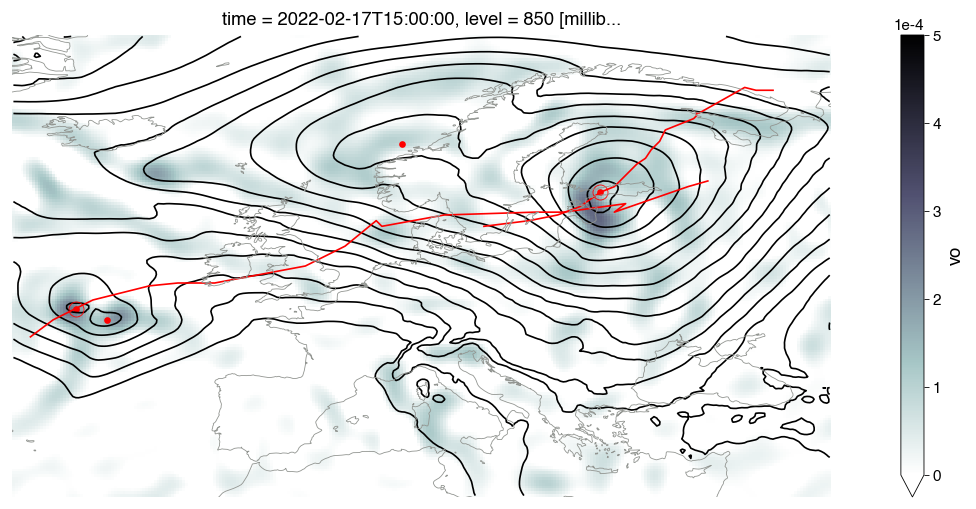

In [15]:
fig,ax = plt.subplots(subplot_kw=dict(projection=crs.PlateCarree()),figsize=(15,5))

choose_time='2022-02-17 15'
contours = 'msl'

if contours == 'msl':
    field_in.sel(time=choose_time).vo.plot(ax=ax,cmap='bone_r',vmin=0,vmax=5e-4)
    field_in.sel(time=choose_time).msl.plot.contour(ax=ax,levels=np.arange(95000,102000,400),colors='k')
    
else:
    field_in.sel(time=choose_time).msl.plot(ax=ax,cmap='bone',vmin=95000,vmax=102000)
    field_in.sel(time=choose_time).vo.plot.contour(ax=ax,levels=np.arange(1e-4,6e-4,1e-4),colors='k')


nodes_out.loc[nodes_out.date==choose_time].plot.scatter('lon','lat',color='r',s=9,ax=ax,marker='o')

tracks_out.loc[tracks_out.date==choose_time,['lon','lat']].plot('lon','lat',ax=ax,ms=9,marker='o',mec='r',mfc='none',lw=0,legend=False)

g=sn.lineplot(data=tracks_out.loc[(tracks_out.date>'2022-02-17')&(tracks_out.date<'2022-02-20')],x='lon',y='lat',size='track_id',sizes=(1,1),color='r',legend=False,ax=ax,estimator=None,zorder=9,sort=False)

ax.coastlines(color='xkcd:grey',lw=0.5,zorder=10)
ax.axis('off')